In [1]:
from pedpy import load_trajectory
from pedpy import (
    Geometry,
    TrajectoryUnit,
    get_invalid_trajectory,
    is_trajectory_valid,
)
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
from shapely import LineString, Polygon
import warnings

warnings.filterwarnings("ignore")

# Setup geometry & measurement area

## Prepare geometry

![](../demos/uni-directional/geo.png)

In [2]:
geometry_poly = Polygon([(-10, -3), (-10, 8), (10, 8), (10, -3)])

geometry = Geometry(walkable_area=geometry_poly)
geometry.add_obstacle(Polygon([(-9, -2), (-9, 0), (9, 0), (9, -2), (-9, -2)]))
geometry.add_obstacle(Polygon([(-9, 5), (-9, 7), (9, 7), (9, 5), (-9, 5)]))

In [ ]:
from pedpy.plotting.plotting import plot_geometry

plot_geometry(geometry=geometry, hole_color="lightgrey").set_aspect("equal")

**For demonstration purposes, wrongly place the obstacle s.th. some pedestrian walk through it!**

In [ ]:
geometry_faulty = Geometry(walkable_area=geometry_poly)
geometry_faulty.add_obstacle(
    Polygon([(-9, -2), (-9, 0.25), (9, 0.25), (9, -2), (-9, -2)])
)
geometry_faulty.add_obstacle(
    Polygon([(-9, 5), (-9, 7), (9, 7), (9, 5), (-9, 5)])
)

## Prepare measurement details

In [3]:
ma = Polygon([(-1.5, 0), (-1.5, 5), (1.5, 5), (1.5, 0), (-1.5, 0)])
ml = LineString([(0, 0), (0, 5)])
passing_offset = 1.0

direction = np.array([-1, 0])

## Load trajectories

`pedpy` can load trajectories from text files, when:
- values are seperated by any whitespace, e.g., space, tab
- file has at least 5 columns in the following order: "ID", "frame", "X", "Y", "Z"
- file may contain comment lines with `#` at in the beginning

For meaningful analysis (and loading of the trajectory file) you also need
- unit of the trajectory (m or cm)
- frame rate

For recent experiments they are encoded in the header of the file, for older you may need to lead the documentation and provide the information in the loading process!

**Examples:**
With frame rate, but no unit
```
# description: UNI_CORR_500_01
# framerate: 25.00
#geometry: geometry.xml

# PersID	Frame	X	Y	Z
1	98	4.6012	1.8909	1.7600
1	99	4.5359	1.8976	1.7600
1	100	4.4470	1.9304	1.7600
...
```

No header at all:
```
1 27 164.834 780.844 168.937
1 28 164.835 771.893 168.937
1 29 163.736 762.665 168.937
1 30 161.967 753.088 168.937
...
```

In [2]:
traj = load_trajectory(
    trajectory_file=pathlib.Path(
        "../demos/uni-directional/traj_UNI_CORR_500_01.txt"
    ),
    default_unit=TrajectoryUnit.METER,  # needs to be provided as it not defined in the file
    # default_frame_rate=25., # can be ignored here as the frame rate is defined in the file
)

## Plot setup

In [ ]:
from pedpy import plot_measurement_setup

fig = plt.figure(figsize=(15, 20))
ax1 = fig.add_subplot(111, aspect="equal")
# ax1 = plot_geometry(geometry=geometry_faulty, ax=ax1) # remove comment to show the borders of the faulty geometry

plot_measurement_setup(
    traj=traj,
    geometry=geometry,
    measurement_areas=[ma],
    measurement_lines=[ml, shapely.offset_curve(ml, passing_offset)],
    traj_width=0.1,
    traj_start_marker=".",
    hole_color="lightgrey",
    ml_color="b",
    ma_color="g",
    ma_alpha=0.1,
    ma_line_color="g",
    ax=ax1,
)
plt.show()

## Validate that trajectory is completely inside the walkable area.

In [ ]:
print(
    f"Trajectory is valid: {is_trajectory_valid(traj=traj, geometry=geometry)}"
)
get_invalid_trajectory(traj=traj, geometry=geometry)

In [ ]:
print(
    f"Trajectory is valid: {is_trajectory_valid(traj=traj, geometry=geometry_faulty)}"
)
get_invalid_trajectory(traj=traj, geometry=geometry_faulty)

# Filter the trajectory data

## Filter by geometrical predicates

### Data inside Polygon

In [ ]:
data_inside_ma = traj.data[shapely.within(traj.data.points, ma)]
data_inside_ma

### Data outside Polygon

In [ ]:
data_outside_ma = traj.data[~shapely.within(traj.data.points, ma)]
data_outside_ma

### Data close to Polygon

In [ ]:
data_close_ma = traj.data[shapely.dwithin(traj.data.points, ma, 1)]
data_close_ma

## Get all data points in a frame range

In [ ]:
data_frame_range = traj.data[
    traj.data.frame.between(300, 400, inclusive="both")
]
data_frame_range

# Density

## Classic density

In [ ]:
from pedpy import compute_classic_density

classic_density = compute_classic_density(
    traj_data=traj.data, measurement_area=ma
)
classic_density

In [ ]:
classic_density.reset_index().plot.line(x="frame", y="classic density")

## Voronoi density

### Compute individual Voronoi Polygons

#### Without cut-off

In [ ]:
from pedpy import compute_individual_voronoi_polygons

individual = compute_individual_voronoi_polygons(
    traj_data=traj.data, geometry=geometry
)

#### With cut-off
**Note:** second argument of `cut_off` needs to be divisable by 4!

In [ ]:
from pedpy import compute_individual_voronoi_polygons

individual_cutoff = compute_individual_voronoi_polygons(
    traj_data=traj.data, geometry=geometry, cut_off=(1.0, 12)
)

### Compute actual Voronoi density

#### Without cut-off

In [ ]:
from pedpy import compute_voronoi_density

density_voronoi, intersecting = compute_voronoi_density(
    individual_voronoi_data=individual, measurement_area=ma
)

In [ ]:
density_voronoi.reset_index().plot.line(x="frame", y="voronoi density")

#### With cut-off

In [ ]:
from pedpy import compute_voronoi_density

density_voronoi_cutoff, intersecting_cutoff = compute_voronoi_density(
    individual_voronoi_data=individual_cutoff, measurement_area=ma
)

In [ ]:
density_voronoi_cutoff.reset_index().plot.line(x="frame", y="voronoi density")

## Comparision

In [ ]:
fig = plt.figure(figsize=(10, 6))
plt.plot(
    classic_density.reset_index().frame,
    classic_density["classic density"].values,
    label="classic",
    lw=3,
)
plt.plot(
    density_voronoi.reset_index().frame,
    density_voronoi["voronoi density"],
    label="voronoi",
    lw=3,
)
plt.plot(
    density_voronoi_cutoff.reset_index().frame,
    density_voronoi_cutoff["voronoi density"],
    label="voronoi cutoff",
    lw=3,
)
plt.xlabel("frame")
plt.ylabel("rho / 1/m^2")
plt.legend()
plt.grid()
plt.show()

## Plot voronoi cells

In [ ]:
from pedpy import plot_voronoi_cells

frame_start = 1200

for frame in range(frame_start, frame_start + 100, 20):
    fig = plt.figure(f"frame = {frame}", figsize=(15, 20))
    fig.suptitle(f"frame = {frame}", y=0.62, fontsize=20)
    df_frame = intersecting[intersecting.frame == frame]
    df_frame = pd.merge(traj.data, df_frame, on=["ID", "frame"])

    ax1 = fig.add_subplot(121, aspect="equal")
    ax1.set_title("w/o cutoff")
    plot_voronoi_cells(
        data=df_frame,
        geometry=geometry,
        color_mode="id",
        show_ped_positions=True,
        ped_size=10,
        ax=ax1,
    )

    df_frame_cutoff = intersecting_cutoff[intersecting_cutoff.frame == frame]
    df_frame_cutoff = pd.merge(traj.data, df_frame_cutoff, on=["ID", "frame"])

    ax2 = fig.add_subplot(122, aspect="equal")
    ax2.set_title("w cutoff")

    plot_voronoi_cells(
        data=df_frame_cutoff,
        geometry=geometry,
        color_mode="id",
        show_ped_positions=True,
        ped_size=10,
        ax=ax2,
    )

    fig.tight_layout()
    plt.show()

## Passing density (individual)

In [ ]:
from pedpy import compute_passing_density
from pedpy import compute_frame_range_in_area

frames_in_area, _ = compute_frame_range_in_area(
    traj_data=traj.data, measurement_line=ml, width=passing_offset
)
passing_density = compute_passing_density(
    density_per_frame=classic_density, frames=frames_in_area
)
passing_density

# Velocity

## Individual speed

In [5]:
from pedpy import compute_individual_velocity

individual_speed = compute_individual_velocity(
    traj_data=traj.data,
    frame_rate=traj.frame_rate,
    frame_step=5,
    x_y_components=True,
)
individual_speed

,ID,frame,speed,v_x,v_y
0,1,98,1.677581,-1.6525,0.2890
1,1,99,1.632689,-1.6085,0.2800
2,1,100,1.457490,-1.4525,0.1205
3,1,101,1.442132,-1.4390,0.0950
4,1,102,1.485936,-1.4825,0.1010
...,...,...,...,...,...
25531,148,872,1.341414,-1.3335,0.1455
25532,148,873,1.353079,-1.3505,0.0835
25533,148,874,1.348107,-1.3480,0.0170
25534,148,875,1.301581,-1.3015,-0.0145


In [ ]:
individual_speed.plot.scatter(x="frame", y="speed")

In [ ]:
individual_speed_direction = compute_individual_velocity(
    traj_data=traj.data,
    frame_rate=traj.frame_rate,
    frame_step=5,
    movement_direction=direction,
    x_y_components=True,
)
individual_speed_direction

In [ ]:
individual_speed_direction.plot.scatter(x="frame", y="speed")

## Mean speed (in measurement area)

In [ ]:
from pedpy import compute_mean_velocity_per_frame

mean_speed = compute_mean_velocity_per_frame(
    traj_data=traj.data,
    measurement_area=ma,
    individual_velocity=individual_speed,
)
mean_speed

In [ ]:
individual_speed

In [ ]:
mean_speed.reset_index().plot.line(x="frame", y="speed")

In [ ]:
mean_speed_direction = compute_mean_velocity_per_frame(
    traj_data=traj.data,
    measurement_area=ma,
    individual_velocity=individual_speed_direction,
)
mean_speed_direction

## Voronoi speed

In [ ]:
from pedpy import compute_voronoi_velocity

In [ ]:
individual_voronoi = intersecting.copy(deep=True)

In [ ]:
voronoi_velocity = compute_voronoi_velocity(
    traj_data=traj.data,
    individual_voronoi_intersection=individual_voronoi,
    individual_velocity=individual_speed,
    measurement_area=ma,
)
voronoi_velocity

In [ ]:
voronoi_velocity.reset_index().plot.line(x="frame", y="voronoi speed")

In [ ]:
voronoi_velocity_direction = compute_voronoi_velocity(
    traj_data=traj.data,
    individual_voronoi_intersection=individual_voronoi,
    individual_velocity=individual_speed_direction,
    measurement_area=ma,
)
voronoi_velocity_direction

## Comparison mean velocity vs voronoi velocity

In [ ]:
fig = plt.figure(figsize=(8, 6))
plt.plot(
    voronoi_velocity.reset_index().frame, voronoi_velocity, label="voronoi"
)
plt.plot(
    voronoi_velocity_direction.reset_index().frame,
    voronoi_velocity_direction,
    label="voronoi direction",
)
plt.plot(mean_speed.reset_index().frame, mean_speed, label="classic")
plt.plot(
    mean_speed_direction.reset_index().frame,
    mean_speed_direction,
    label="classic direction",
)
plt.xlabel("frame")
plt.ylabel("v / m/s")
plt.legend()
plt.grid()
plt.show()

## Passing speed (individual)

In [ ]:
from pedpy import compute_passing_speed
from pedpy import compute_frame_range_in_area

frames_in_area, _ = compute_frame_range_in_area(
    traj_data=traj.data, measurement_line=ml, width=passing_offset
)
passing_speed = compute_passing_speed(
    frames_in_area=frames_in_area,
    frame_rate=traj.frame_rate,
    distance=passing_offset,
)
passing_speed

# Flow

## N-t diagram

In [ ]:
from pedpy import compute_n_t

nt, crossing = compute_n_t(
    traj_data=traj.data, measurement_line=ml, frame_rate=traj.frame_rate
)

In [ ]:
nt.plot(x="Time [s]")

## Flow

In [ ]:
from pedpy import compute_flow

delta_t = 100
flow = compute_flow(
    nt=nt,
    crossing_frames=crossing,
    individual_speed=individual_speed,
    delta_t=delta_t,
    frame_rate=traj.frame_rate,
)
flow

# Neighborhood

In [ ]:
from pedpy import compute_neighbors

neighbors = compute_neighbors(individual_cutoff)
neighbors

In [ ]:
frame = 231

voronoi_neighbors = pd.merge(
    individual_cutoff[individual_cutoff.frame == frame],
    neighbors[neighbors.frame == frame],
    on=["ID", "frame"],
)

for base in voronoi_neighbors["ID"].values[8:10]:
    base_neighbors = voronoi_neighbors[voronoi_neighbors["ID"] == base][
        "neighbors"
    ].values[0]

    fig = plt.figure(f"frame = {frame}", figsize=(20, 10))

    ax = fig.add_subplot(111, aspect="equal")
    fig.suptitle(f"id = {base}")
    plot_geometry(ax=ax, geometry=geometry)

    for _, row in voronoi_neighbors.iterrows():
        poly = row["individual voronoi"]
        ped_id = row["ID"]

        are_neighbors = ped_id in base_neighbors

        color = "gray"
        if ped_id == base:
            color = "green"

        if are_neighbors:
            color = "red"

        ax.plot(*poly.exterior.xy, alpha=1, color=color)
        ax.fill(*poly.exterior.xy, alpha=0.5, color=color)

    fig.tight_layout()
    plt.show()

# Profiles

In [ ]:
from pedpy import (
    compute_profiles,
    compute_individual_voronoi_polygons,
    compute_individual_velocity,
    VelocityMethod,
)

In [ ]:
min_frame_profiles = 900
max_frame_profiles = 1000

frames_data = traj.data[
    traj.data.frame.isin(range(min_frame_profiles, max_frame_profiles))
]

individual_frames = compute_individual_voronoi_polygons(
    traj_data=frames_data,
    geometry=geometry,
    cut_off=(0.8, 12),
)

individual_speed = compute_individual_velocity(
    traj_data=frames_data,
    frame_rate=traj.frame_rate,
    frame_step=5,
)

In [ ]:
density_profiles, velocity_profiles = compute_profiles(
    individual_voronoi_velocity_data=pd.merge(
        individual_frames, individual_speed, on=["ID", "frame"]
    ),
    walkable_area=geometry.walkable_area,
    grid_size=0.2,
    velocity_method=VelocityMethod.VORONOI,
)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

bounds = geometry.walkable_area.bounds

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

ax0.set_title("Density")
cm = ax0.imshow(
    np.mean(density_profiles, axis=0),
    extent=[bounds[0], bounds[2], bounds[1], bounds[3]],
    interpolation="None",
    cmap="jet",
    vmin=0,
    vmax=0.5,
)
fig.colorbar(cm, ax=ax0, shrink=0.3)
ax0.plot(*geometry.walkable_area.exterior.xy, color="w")

ax1.set_title("Velocity")
cm = ax1.imshow(
    np.mean(velocity_profiles, axis=0),
    extent=[bounds[0], bounds[2], bounds[1], bounds[3]],
    cmap="jet_r",
    vmin=0,
    vmax=1.5,
)
fig.colorbar(cm, ax=ax1, shrink=0.3)

ax1.plot(*geometry.walkable_area.exterior.xy, color="w")

fig.tight_layout()

# What to do with the results?

## Combine multiple DataFrames


In [ ]:
traj.data

In [ ]:
individual

In [ ]:
data_with_voronoi_cells = traj.data.merge(intersecting, on=["ID", "frame"])
data_with_voronoi_cells

In [ ]:
data_with_voronoi_cells_speed = data_with_voronoi_cells.merge(
    individual_speed[["ID", "frame", "speed"]], on=["ID", "frame"]
)
data_with_voronoi_cells_speed

## Save in files

### Create directories to store the results

In [ ]:
pathlib.Path("results_introduction/profiles/velocity").mkdir(
    parents=True, exist_ok=True
)
pathlib.Path("results_introduction/profiles/density").mkdir(
    parents=True, exist_ok=True
)

results_directory = pathlib.Path("results_introduction")

### Save Pandas dataframe (result from everything but profiles) as csv

In [ ]:
import csv

data_with_voronoi_cells_speed["individual density"] = shapely.area(
    data_with_voronoi_cells_speed["individual voronoi"]
)

with open(
    results_directory / "individual_result.csv", "w"
) as individual_output_file:
    individual_output_file.write(f"#framerate:	{traj.frame_rate}\n\n")
    data_with_voronoi_cells_speed[
        [
            "ID",
            "frame",
            "X",
            "Y",
            "Z",
            "individual density",
            "speed",
            "individual voronoi",
            "intersection voronoi",
        ]
    ].to_csv(
        individual_output_file,
        mode="a",
        header=True,
        sep="\t",
        index_label=False,
        index=False,
        quoting=csv.QUOTE_NONNUMERIC,
    )

### Save numpy arrays (result from profiles) as txt

In [ ]:
results_directory_density = results_directory / "profiles/density"
results_directory_velocity = results_directory / "profiles/velocity"

for i in range(len(range(min_frame_profiles, min_frame_profiles + 10))):
    frame = min_frame_profiles + i
    np.savetxt(
        results_directory_density / f"density_frame_{frame:05d}.txt",
        density_profiles[i],
    )
    np.savetxt(
        results_directory_velocity / f"velocity_frame_{frame:05d}.txt",
        velocity_profiles[i],
    )

# FOO!

In [4]:
frame_step = 15

In [6]:
all = traj.data.copy(deep=True)
ped = traj.data[traj.data.ID == 1]

In [5]:
def compute_movement_current(traj_data: pd.DataFrame, frame_step: int):
    df_movement = traj_data.copy(deep=True)

    frame_infos = df_movement.groupby(by="ID").agg(
        frame_min=("frame", np.min), frame_max=("frame", np.max)
    )
    df_movement = df_movement.merge(frame_infos, on="ID")

    df_movement["distance_min"] = np.abs(
        df_movement.frame - df_movement["frame_min"]
    )
    df_movement["distance_max"] = np.abs(
        df_movement.frame - df_movement["frame_max"]
    )

    df_movement["start_frame"] = df_movement.frame - frame_step
    df_movement.loc[
        df_movement.distance_min < frame_step, "start_frame"
    ] = df_movement[df_movement.distance_min < frame_step]["frame_min"]

    df_movement["end_frame"] = df_movement.frame + frame_step
    df_movement.loc[
        df_movement.distance_max < frame_step, "end_frame"
    ] = df_movement[df_movement.distance_min < frame_step]["frame_max"]

    start = (
        pd.merge(
            df_movement[["ID", "frame", "start_frame"]],
            df_movement[["ID", "frame", "points"]],
            left_on=["ID", "start_frame"],
            right_on=["ID", "frame"],
            suffixes=("", "_drop"),
        )
        .drop("frame_drop", axis=1)
        .rename({"points": "start"}, axis=1)
    )

    end = (
        pd.merge(
            df_movement[["ID", "frame", "end_frame"]],
            df_movement[["ID", "frame", "points"]],
            left_on=["ID", "end_frame"],
            right_on=["ID", "frame"],
            suffixes=("", "_drop"),
        )
        .drop("frame_drop", axis=1)
        .rename({"points": "end"}, axis=1)
    )

    return pd.merge(start, end, on=["ID", "frame"]).dropna()[
        ["ID", "frame", "start", "end", "start_frame", "end_frame"]
    ]

    # return df_movement

In [6]:
current = compute_movement_current(traj_data=traj.data, frame_step=frame_step)
current

,ID,frame,start,end,start_frame,end_frame
0,1,98,POINT (4.6012 1.8909),POINT (3.6433 1.9209),98,113.0
1,1,99,POINT (4.6012 1.8909),POINT (3.5911 1.9182),98,114.0
2,1,100,POINT (4.6012 1.8909),POINT (3.5312 1.9109),98,115.0
3,1,101,POINT (4.6012 1.8909),POINT (3.4747 1.8991),98,116.0
4,1,102,POINT (4.6012 1.8909),POINT (3.4252 1.8946),98,117.0
...,...,...,...,...,...,...
23311,148,857,POINT (-3.5936 1.4134),POINT (-5.1631 1.484),842,872.0
23312,148,858,POINT (-3.6505 1.4215),POINT (-5.2162 1.4826),843,873.0
23313,148,859,POINT (-3.7037 1.4286),POINT (-5.2685 1.4796),844,874.0
23314,148,860,POINT (-3.7595 1.4347),POINT (-5.3164 1.4793),845,875.0


In [8]:
def compute_movement_cutting(
    traj_data: pd.DataFrame, frame_step: int, bidirectional: bool = True
):
    df_movement = traj_data.copy(deep=True)

    frame_infos = df_movement.groupby(by="ID").agg(
        frame_min=("frame", np.min), frame_max=("frame", np.max)
    )
    df_movement = df_movement.merge(frame_infos, on="ID")

    df_movement["distance_min"] = np.abs(
        df_movement.frame - df_movement["frame_min"]
    )
    df_movement["distance_max"] = np.abs(
        df_movement.frame - df_movement["frame_max"]
    )
    df_movement = df_movement.drop(
        df_movement[df_movement["distance_min"] < frame_step].index
    ).drop(df_movement[df_movement["distance_max"] < frame_step].index)
    df_movement["start_frame"] = df_movement.frame - frame_step
    df_movement["end_frame"] = df_movement.frame + frame_step

    start = (
        pd.merge(
            df_movement[["ID", "frame", "start_frame"]],
            df_movement[["ID", "frame", "points"]],
            left_on=["ID", "start_frame"],
            right_on=["ID", "frame"],
            suffixes=("", "_drop"),
        )
        .drop("frame_drop", axis=1)
        .rename({"points": "start"}, axis=1)
    )

    end = (
        pd.merge(
            df_movement[["ID", "frame", "end_frame"]],
            df_movement[["ID", "frame", "points"]],
            left_on=["ID", "end_frame"],
            right_on=["ID", "frame"],
            suffixes=("", "_drop"),
        )
        .drop("frame_drop", axis=1)
        .rename({"points": "end"}, axis=1)
    )

    return pd.merge(start, end, on=["ID", "frame"]).dropna()[
        ["ID", "frame", "start", "end", "start_frame", "end_frame"]
    ]

In [7]:
cutting = compute_movement_cutting(traj_data=traj.data, frame_step=5)
cutting

NameError: name 'df_m' is not defined

In [121]:
cutting_speed

,ID,frame,speed,v_x,v_y
0,1,108,1.570039,-1.56850,-0.06950
1,1,109,1.560262,-1.55775,-0.08850
2,1,110,1.567045,-1.56325,-0.10900
3,1,111,1.566337,-1.56000,-0.14075
4,1,112,1.527291,-1.51700,-0.17700
...,...,...,...,...,...
22571,148,862,1.285636,-1.28000,0.12025
22572,148,863,1.267240,-1.25800,0.15275
22573,148,864,1.262222,-1.24975,0.17700
22574,148,865,1.260537,-1.24625,0.18925


In [9]:
def compute_movement_adaptive(traj_data: pd.DataFrame, frame_step: int):
    df_movement = traj_data.copy(deep=True)

    frame_infos = df_movement.groupby(by="ID").agg(
        frame_min=("frame", np.min), frame_max=("frame", np.max)
    )
    df_movement = df_movement.merge(frame_infos, on="ID")

    df_movement["distance_min"] = np.abs(
        df_movement.frame - df_movement["frame_min"]
    )
    df_movement["distance_max"] = np.abs(
        df_movement.frame - df_movement["frame_max"]
    )
    df_movement["window_size"] = np.minimum(
        frame_step,
        np.minimum(
            df_movement.distance_min.values, df_movement.distance_max.values
        ),
    )
    df_movement["start_frame"] = df_movement.frame - df_movement.window_size
    df_movement["end_frame"] = df_movement.frame + df_movement.window_size

    start = (
        pd.merge(
            df_movement[["ID", "frame", "start_frame"]],
            df_movement[["ID", "frame", "points"]],
            left_on=["ID", "start_frame"],
            right_on=["ID", "frame"],
            suffixes=("", "_drop"),
        )
        .drop("frame_drop", axis=1)
        .rename({"points": "start"}, axis=1)
    )

    end = (
        pd.merge(
            df_movement[["ID", "frame", "end_frame"]],
            df_movement[["ID", "frame", "points"]],
            left_on=["ID", "end_frame"],
            right_on=["ID", "frame"],
            suffixes=("", "_drop"),
        )
        .drop("frame_drop", axis=1)
        .rename({"points": "end"}, axis=1)
    )

    return pd.merge(start, end, on=["ID", "frame"]).dropna()[
        ["ID", "frame", "start", "end", "start_frame", "end_frame"]
    ]

In [10]:
adaptive = compute_movement_adaptive(traj.data, frame_step)

In [7]:
all = traj.data.copy(deep=True)

In [8]:
frame_infos = all.groupby(by="ID").agg(
    frame_min=("frame", np.min), frame_max=("frame", np.max)
)
all = all.merge(frame_infos, on="ID")

In [9]:
all

,ID,frame,X,Y,Z,points,frame_min,frame_max
0,1,98,4.6012,1.8909,1.76,POINT (4.6012 1.8909),98,285
1,1,99,4.5359,1.8976,1.76,POINT (4.5359 1.8976),98,285
2,1,100,4.4470,1.9304,1.76,POINT (4.447 1.9304),98,285
3,1,101,4.3865,1.9364,1.76,POINT (4.3865 1.9364),98,285
4,1,102,4.3285,1.9452,1.76,POINT (4.3285 1.9452),98,285
...,...,...,...,...,...,...,...,...
25531,148,872,-5.1631,1.4840,1.76,POINT (-5.1631 1.484),694,876
25532,148,873,-5.2162,1.4826,1.76,POINT (-5.2162 1.4826),694,876
25533,148,874,-5.2685,1.4796,1.76,POINT (-5.2685 1.4796),694,876
25534,148,875,-5.3164,1.4793,1.76,POINT (-5.3164 1.4793),694,876


In [16]:
all["distance_min"] = np.abs(all.frame - all["frame_min"])
all["distance_max"] = np.abs(all.frame - all["frame_max"])
all["window_size"] = np.minimum(
    frame_step, np.minimum(all.distance_min.values, all.distance_max.values)
)
all["start_frame"] = all.frame - all.window_size
all["end_frame"] = all.frame + all.window_size

In [17]:
all[all.ID == 1].sort_values(by="frame", ascending=False)

,ID,frame,X,Y,Z,points,frame_min,frame_max,distance_min,distance_max,window_size,start_frame,end_frame
187,1,285,-5.3852,1.8453,1.76,POINT (-5.3852 1.8453),98,285,187,0,0,285,285
186,1,284,-5.3358,1.8392,1.76,POINT (-5.3358 1.8392),98,285,186,1,1,283,285
185,1,283,-5.2846,1.8341,1.76,POINT (-5.2846 1.8341),98,285,185,2,2,281,285
184,1,282,-5.2357,1.8297,1.76,POINT (-5.2357 1.8297),98,285,184,3,3,279,285
183,1,281,-5.1831,1.8269,1.76,POINT (-5.1831 1.8269),98,285,183,4,4,277,285
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,1,102,4.3285,1.9452,1.76,POINT (4.3285 1.9452),98,285,4,183,4,98,106
3,1,101,4.3865,1.9364,1.76,POINT (4.3865 1.9364),98,285,3,184,3,98,104
2,1,100,4.4470,1.9304,1.76,POINT (4.447 1.9304),98,285,2,185,2,98,102
1,1,99,4.5359,1.8976,1.76,POINT (4.5359 1.8976),98,285,1,186,1,98,100


In [34]:
start = (
    pd.merge(
        all[["ID", "frame", "start_frame"]],
        all[["ID", "frame", "points"]],
        left_on=["ID", "start_frame"],
        right_on=["ID", "frame"],
        suffixes=("", "_drop"),
    )
    .drop("frame_drop", axis=1)
    .rename({"points": "start"}, axis=1)
)
start

,ID,frame,start_frame,start
0,1,98,98,POINT (4.6012 1.8909)
1,1,99,98,POINT (4.6012 1.8909)
2,1,100,98,POINT (4.6012 1.8909)
3,1,101,98,POINT (4.6012 1.8909)
4,1,102,98,POINT (4.6012 1.8909)
...,...,...,...,...
25531,148,872,868,POINT (-4.9461 1.4659)
25532,148,873,870,POINT (-5.0561 1.4822)
25533,148,874,872,POINT (-5.1631 1.484)
25534,148,875,874,POINT (-5.2685 1.4796)


In [36]:
end = (
    pd.merge(
        all[["ID", "frame", "end_frame"]],
        all[["ID", "frame", "points"]],
        left_on=["ID", "end_frame"],
        right_on=["ID", "frame"],
        suffixes=("", "_drop"),
    )
    .drop("frame_drop", axis=1)
    .rename({"points": "end"}, axis=1)
)
end

,ID,frame,end_frame,end
0,1,98,98,POINT (4.6012 1.8909)
1,1,99,100,POINT (4.447 1.9304)
2,1,100,102,POINT (4.3285 1.9452)
3,1,101,104,POINT (4.2142 1.9536)
4,1,102,106,POINT (4.0987 1.9554)
...,...,...,...,...
25531,148,872,876,POINT (-5.3606 1.4787)
25532,148,873,876,POINT (-5.3606 1.4787)
25533,148,874,876,POINT (-5.3606 1.4787)
25534,148,875,876,POINT (-5.3606 1.4787)


In [38]:
movement = pd.merge(start, end, on=["ID", "frame"])
movement

,ID,frame,start_frame,start,end_frame,end
0,1,98,98,POINT (4.6012 1.8909),98,POINT (4.6012 1.8909)
1,1,99,98,POINT (4.6012 1.8909),100,POINT (4.447 1.9304)
2,1,100,98,POINT (4.6012 1.8909),102,POINT (4.3285 1.9452)
3,1,101,98,POINT (4.6012 1.8909),104,POINT (4.2142 1.9536)
4,1,102,98,POINT (4.6012 1.8909),106,POINT (4.0987 1.9554)
...,...,...,...,...,...,...
25531,148,872,868,POINT (-4.9461 1.4659),876,POINT (-5.3606 1.4787)
25532,148,873,870,POINT (-5.0561 1.4822),876,POINT (-5.3606 1.4787)
25533,148,874,872,POINT (-5.1631 1.484),876,POINT (-5.3606 1.4787)
25534,148,875,874,POINT (-5.2685 1.4796),876,POINT (-5.3606 1.4787)


In [14]:
from pedpy.methods.velocity_calculator import _compute_individual_speed

adaptive_speed = _compute_individual_speed(
    movement_data=adaptive, frame_rate=traj.frame_rate
)
# cutting_speed = _compute_individual_speed(movement_data=cutting, frame_rate=traj.frame_rate)
current_speed = _compute_individual_speed(
    movement_data=current, frame_rate=traj.frame_rate
)

In [120]:
cutting_speed

,ID,frame,speed,v_x,v_y
0,1,108,1.570039,-1.56850,-0.06950
1,1,109,1.560262,-1.55775,-0.08850
2,1,110,1.567045,-1.56325,-0.10900
3,1,111,1.566337,-1.56000,-0.14075
4,1,112,1.527291,-1.51700,-0.17700
...,...,...,...,...,...
22571,148,862,1.285636,-1.28000,0.12025
22572,148,863,1.267240,-1.25800,0.15275
22573,148,864,1.262222,-1.24975,0.17700
22574,148,865,1.260537,-1.24625,0.18925


In [16]:
from pedpy import compute_individual_velocity

old = compute_individual_velocity(
    traj_data=traj.data, frame_rate=traj.frame_rate, frame_step=frame_step
)
old

,ID,frame,speed,v_x,v_y
0,1,98,1.597283,-1.596500,0.050000
1,1,99,1.575041,-1.574667,0.034333
2,1,100,1.526679,-1.526333,-0.032500
3,1,101,1.520938,-1.519667,-0.062167
4,1,102,1.507860,-1.505500,-0.084333
...,...,...,...,...,...
25531,148,872,1.304196,-1.297833,0.128667
25532,148,873,1.295340,-1.288833,0.129667
25533,148,874,1.288449,-1.282500,0.123667
25534,148,875,1.270474,-1.264667,0.121333


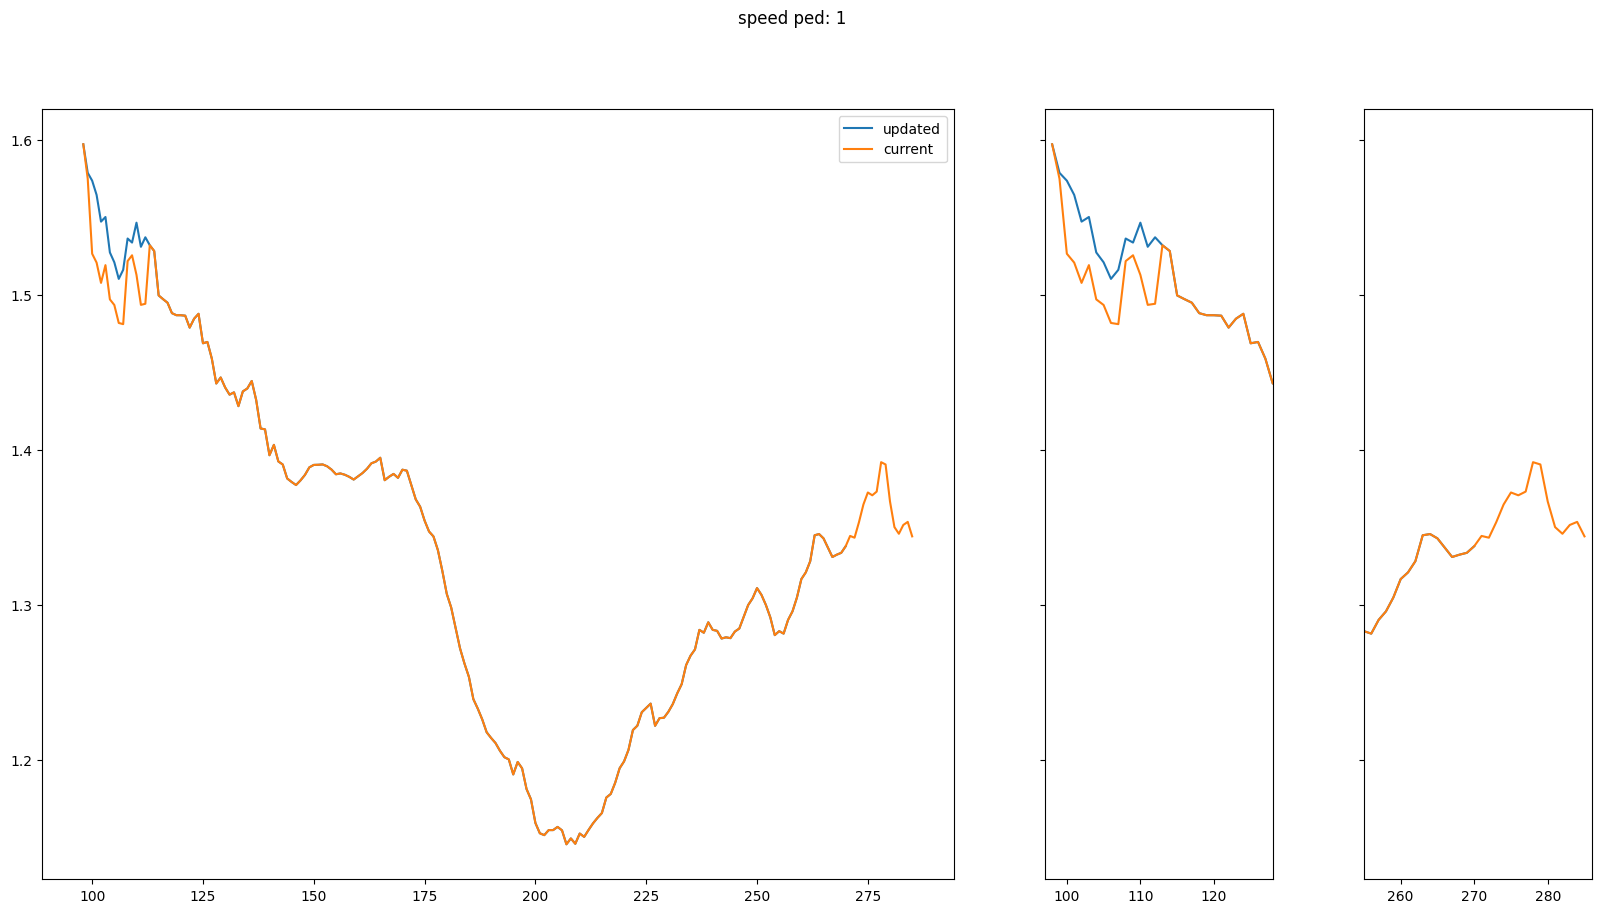

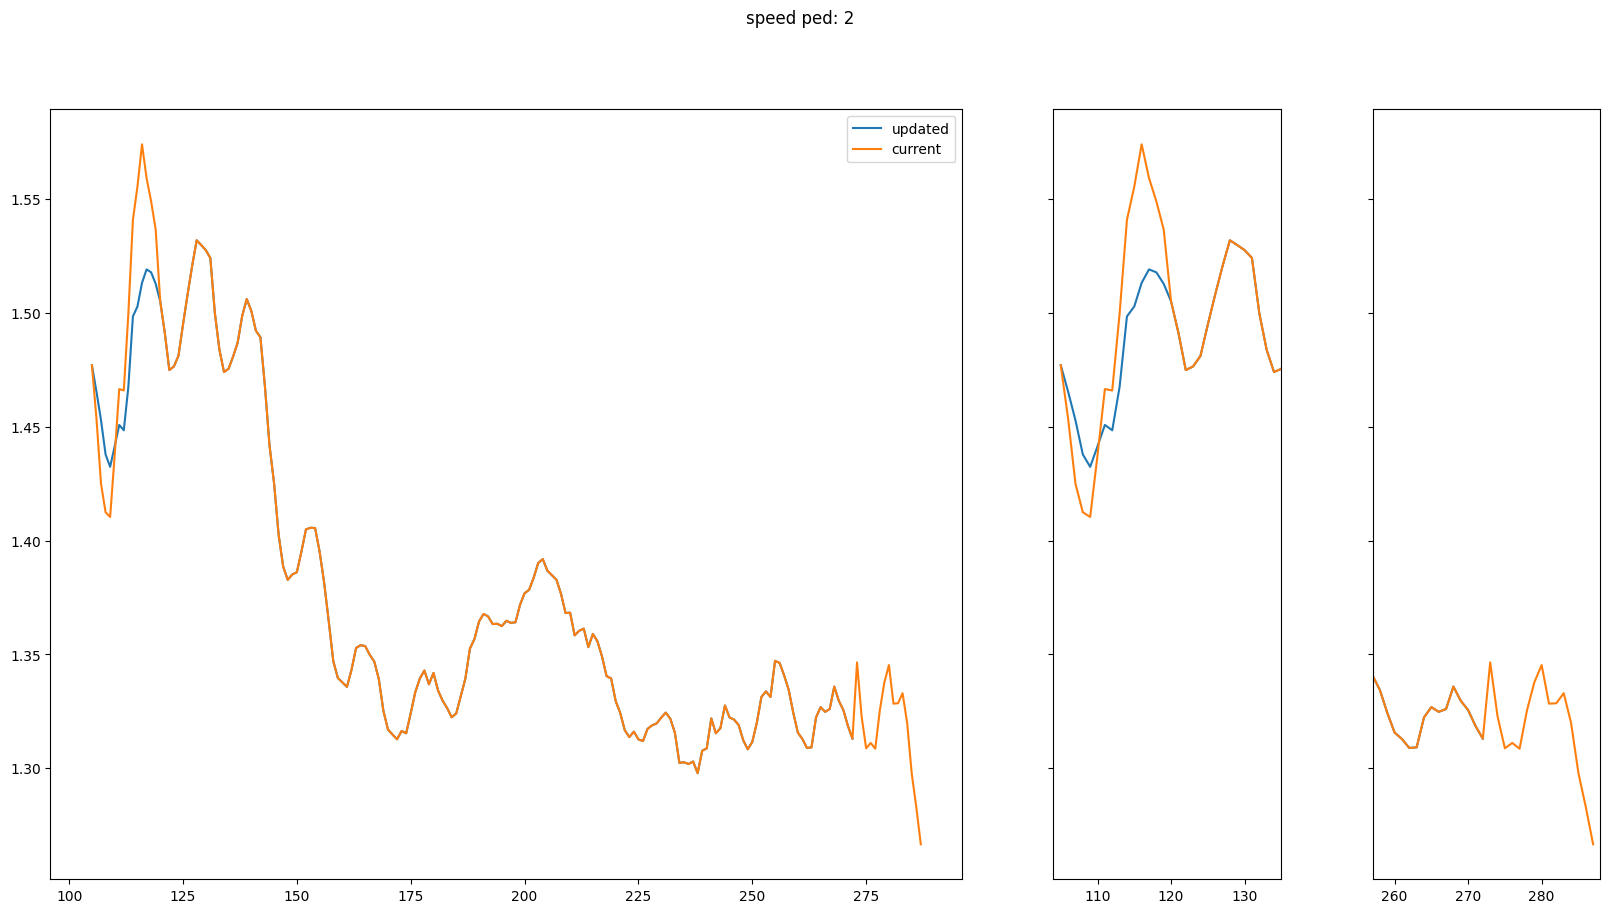

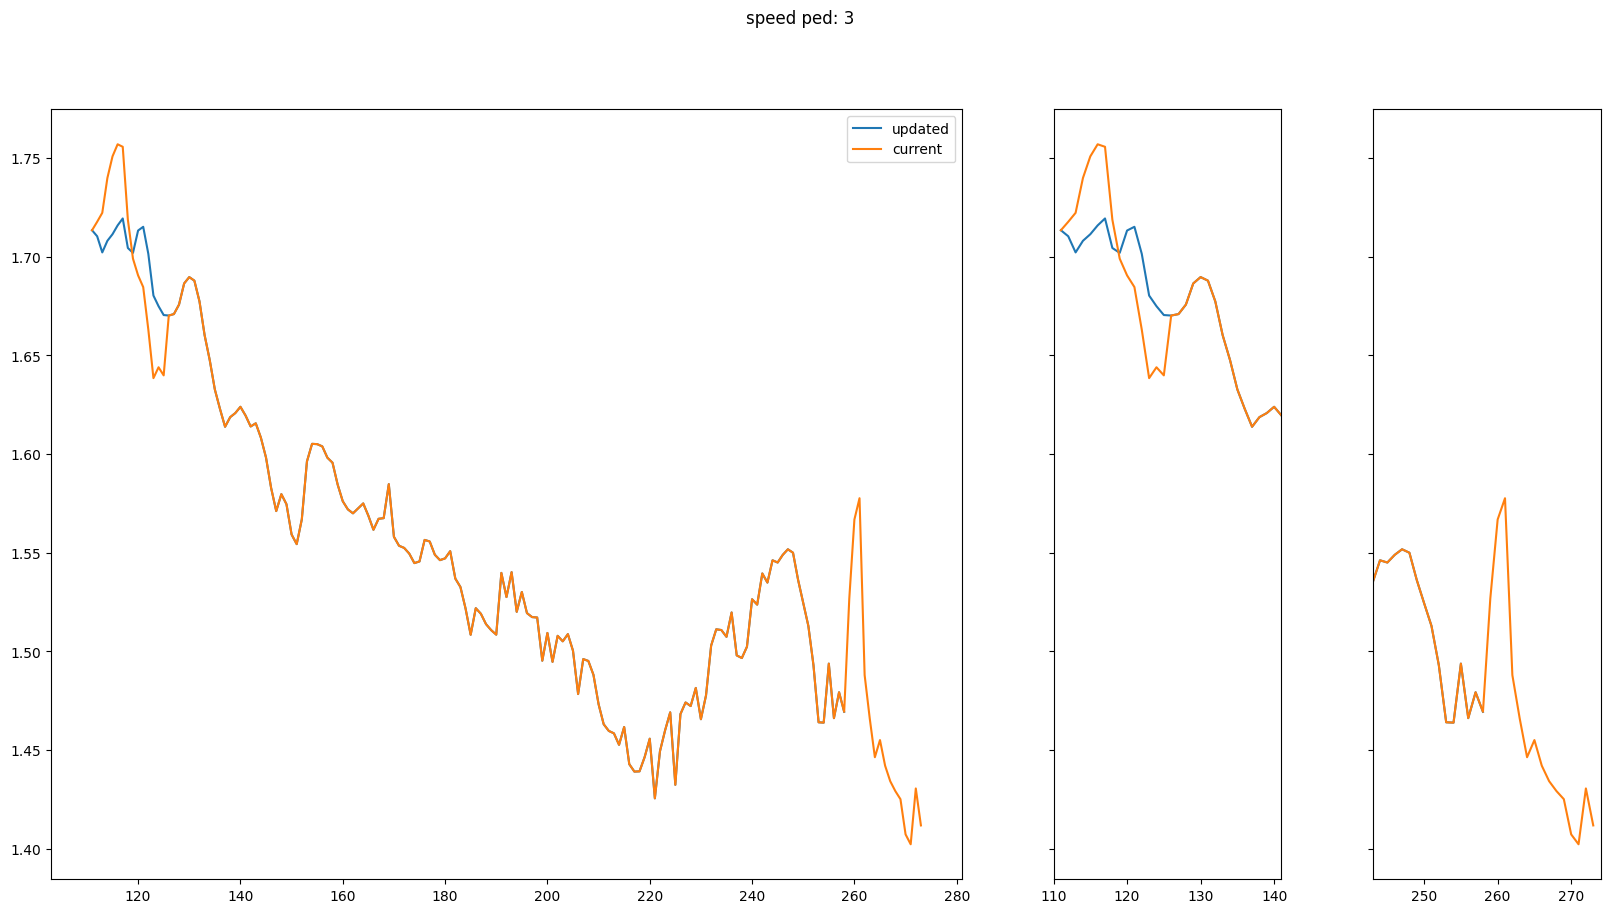

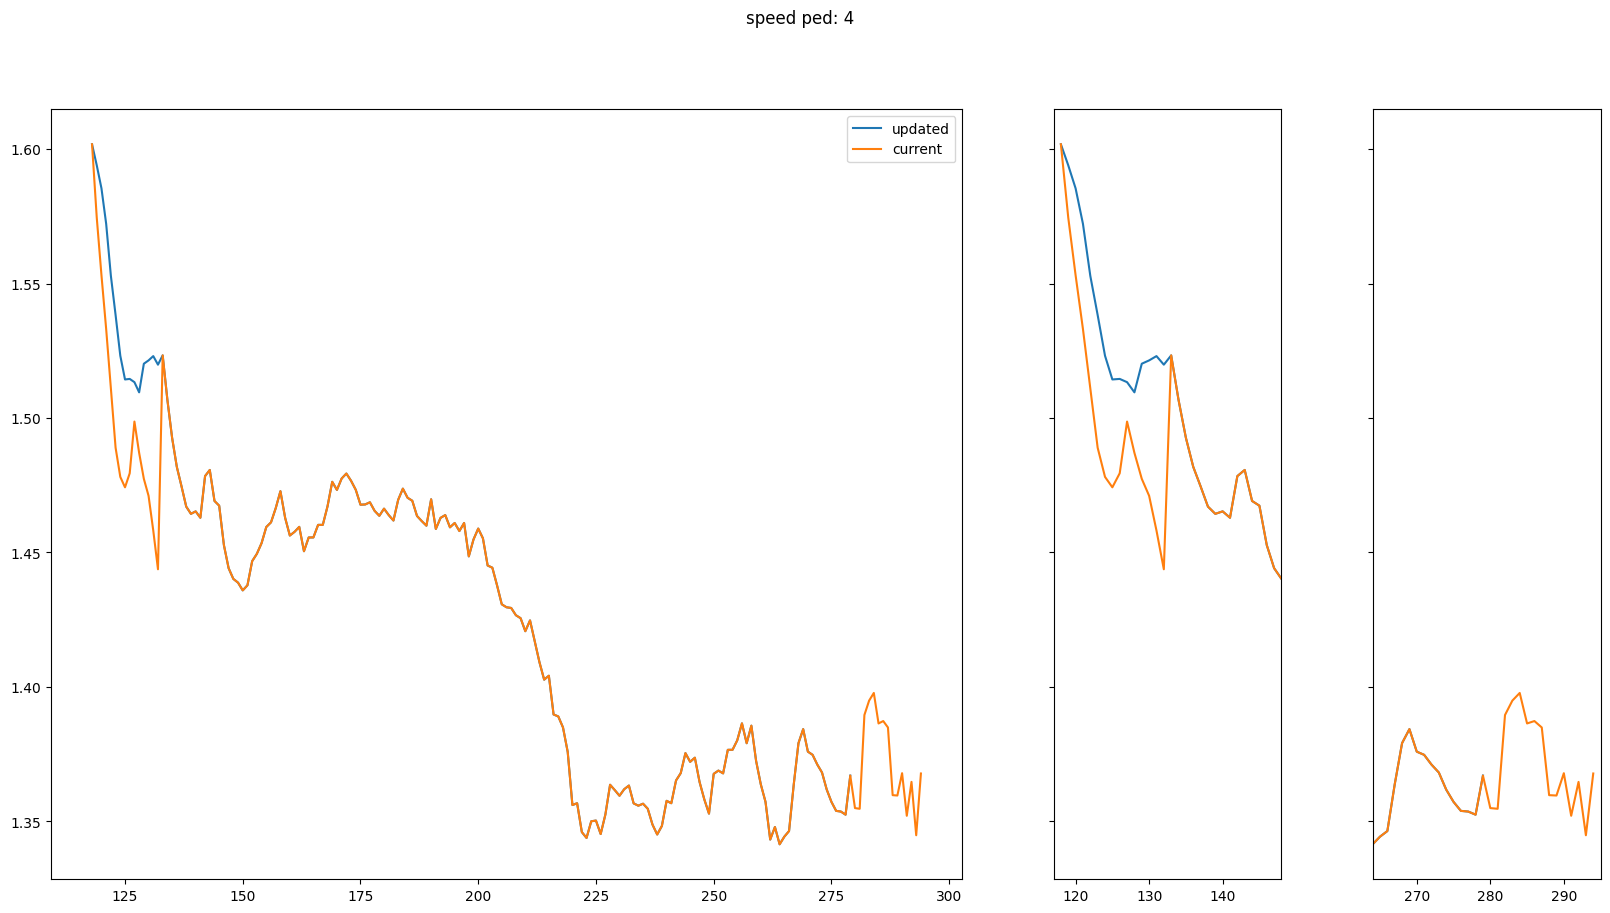

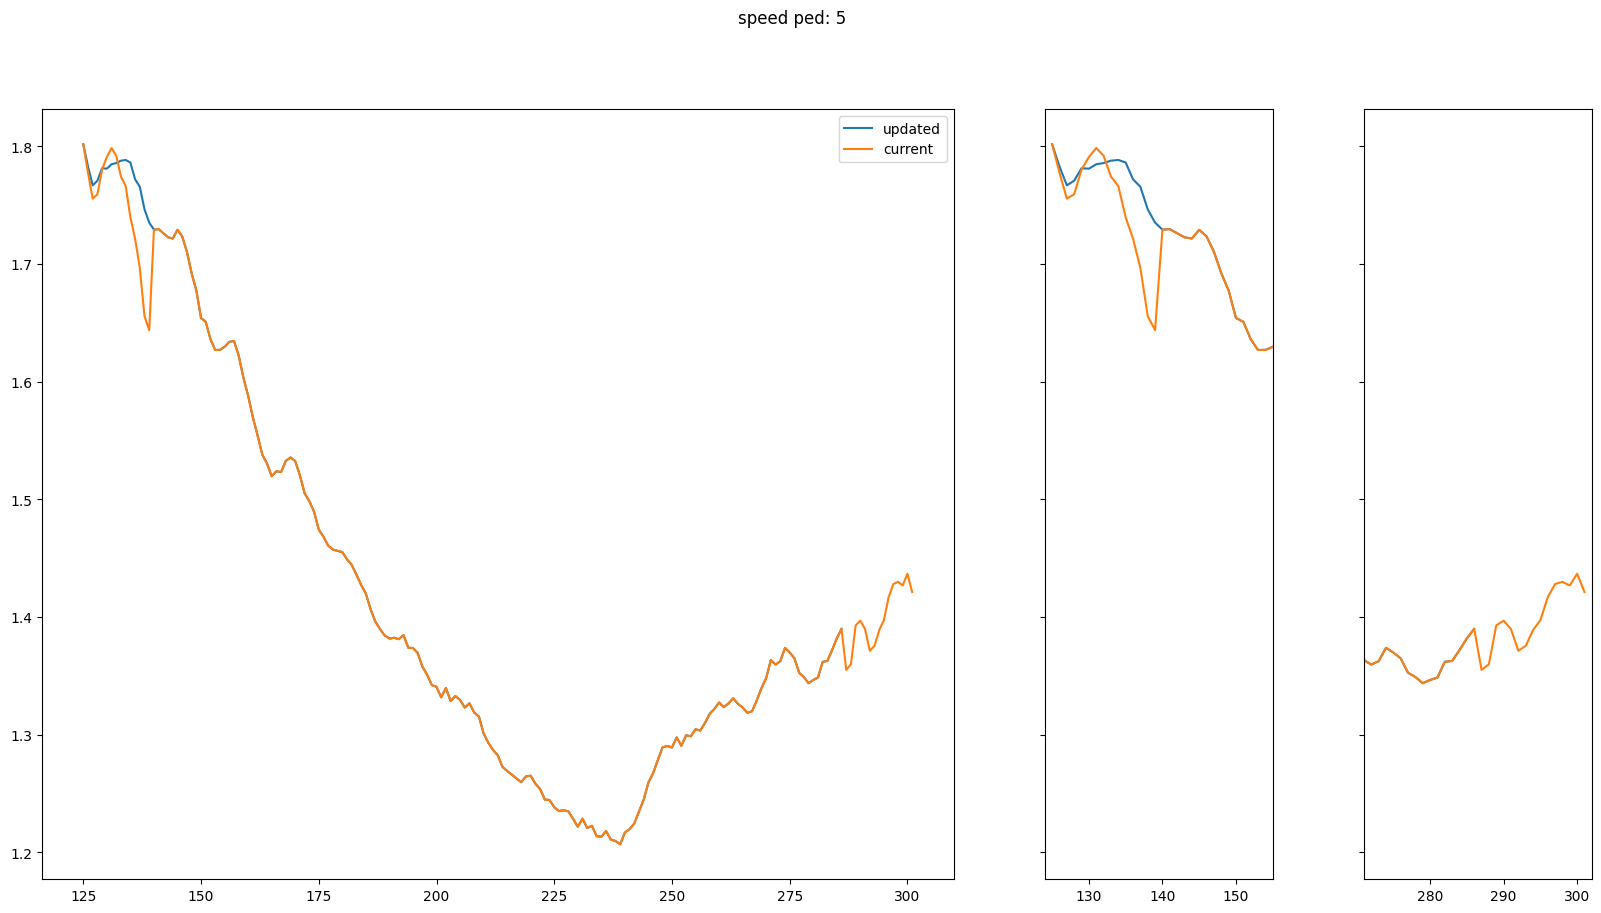

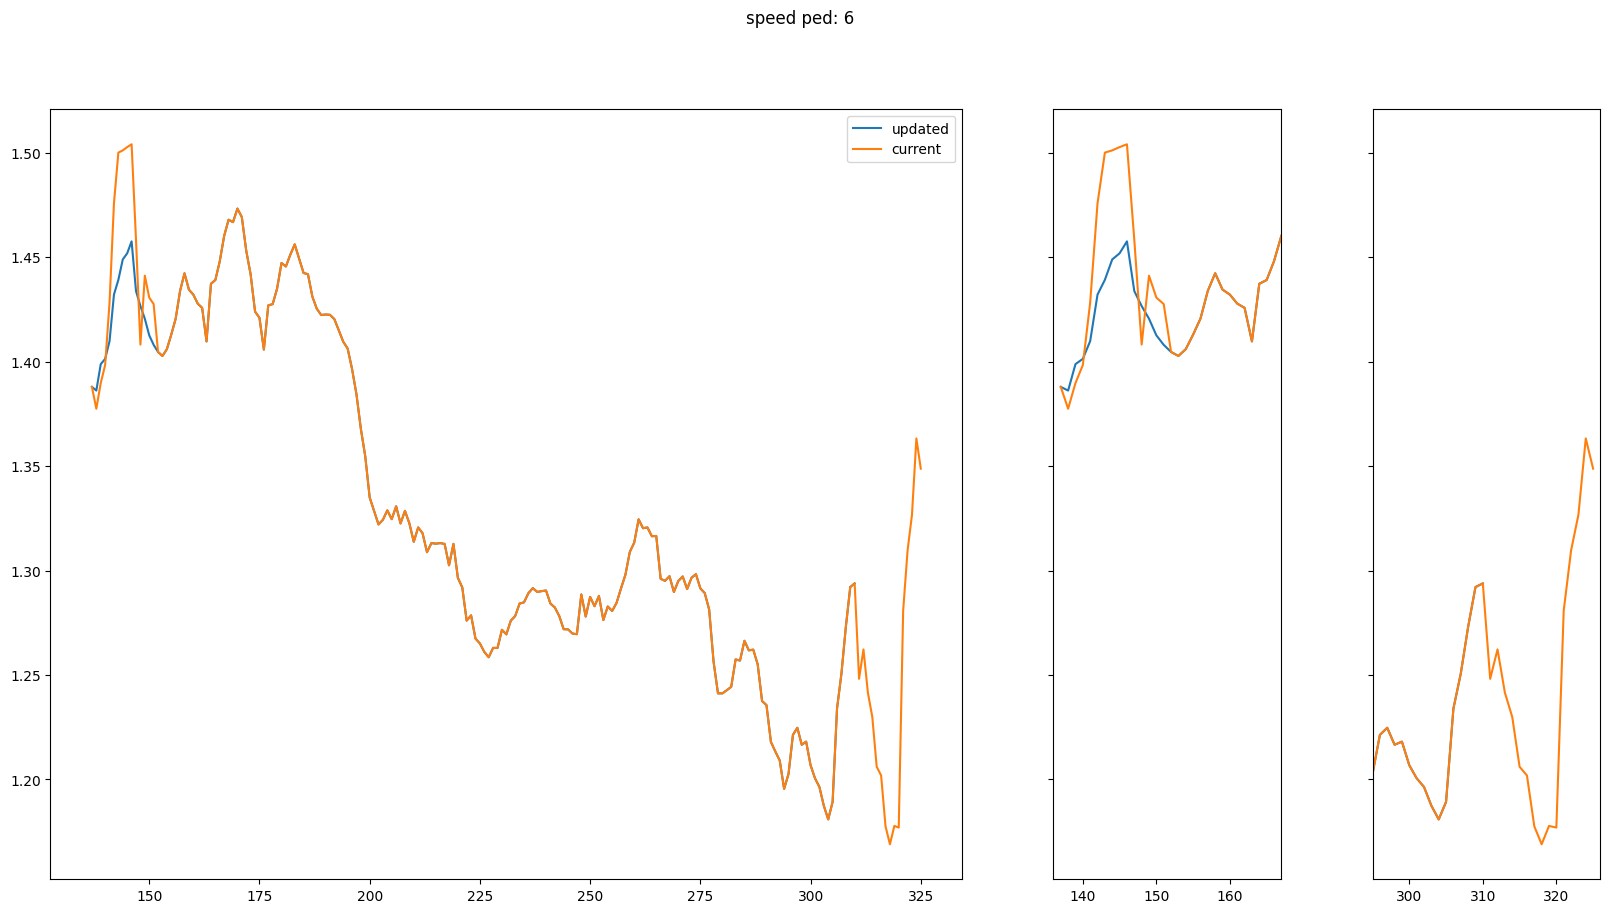

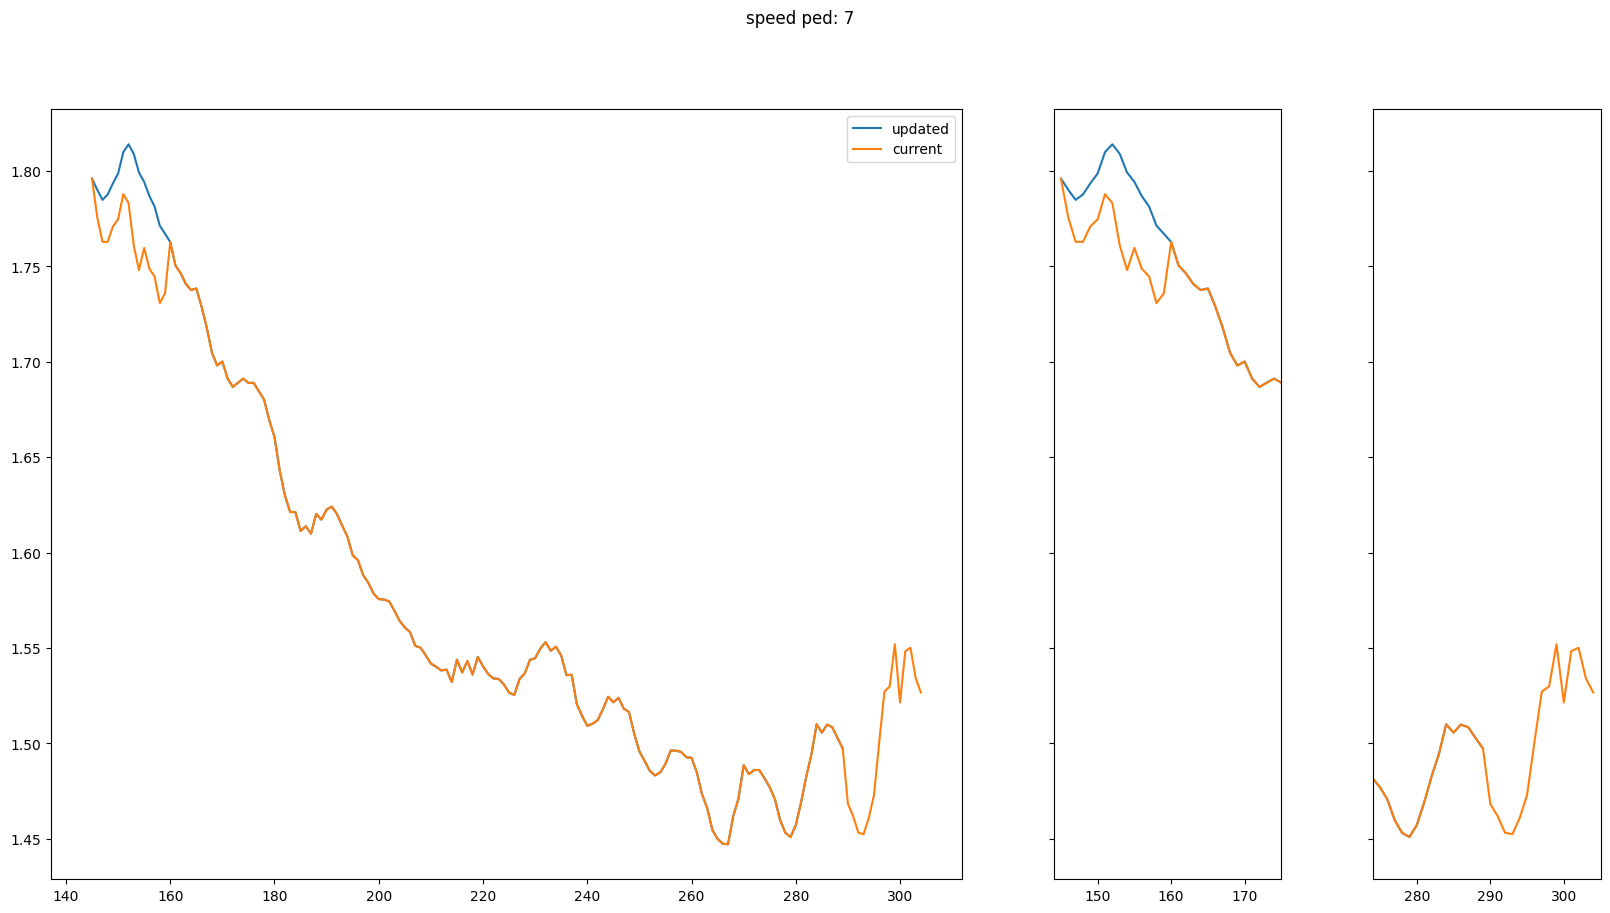

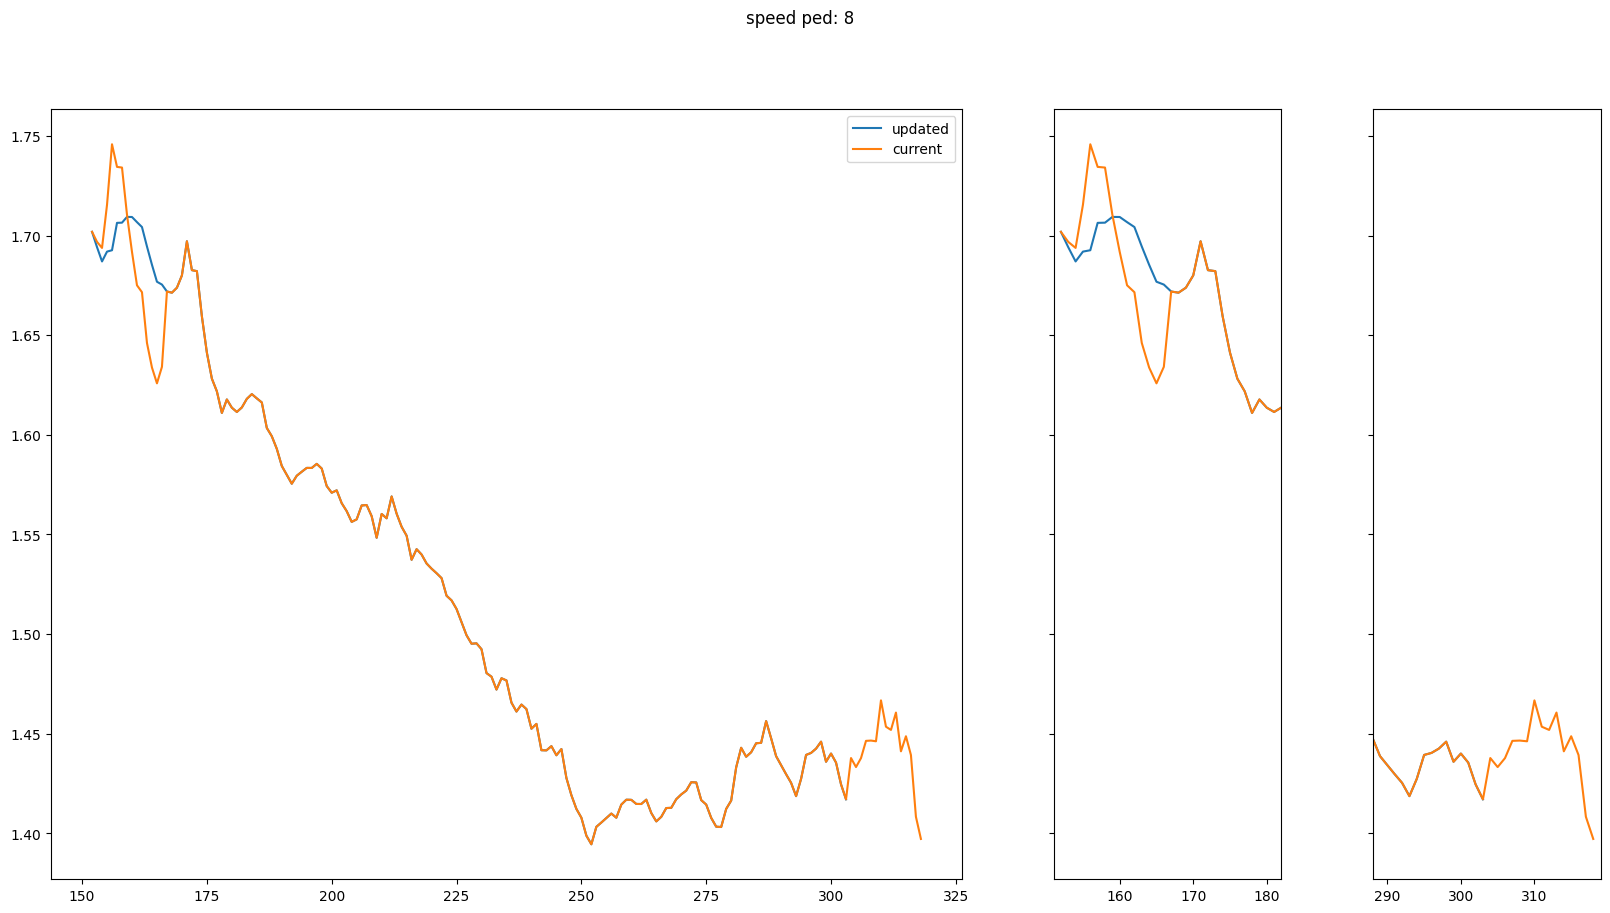

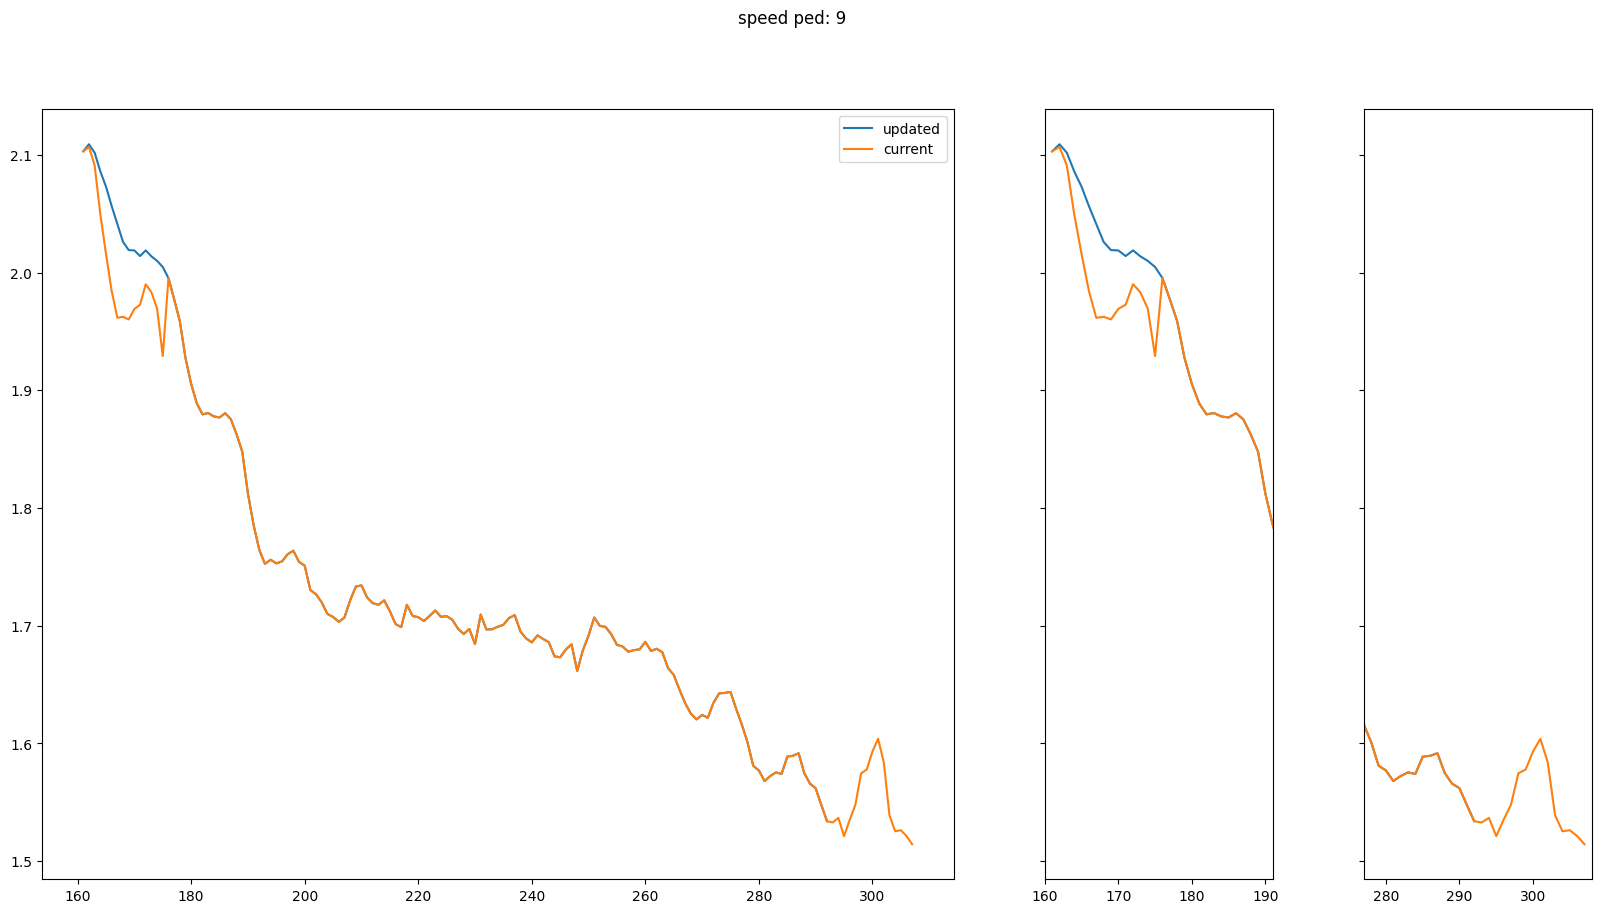

In [20]:
ids = range(1, 10)

for ped_id in ids:

    fig, axs = plt.subplots(
        1, 3, figsize=(20, 10), width_ratios=[8, 2, 2], sharey=True
    )
    fig.suptitle(f"speed ped: {ped_id}")
    axs[0].plot(
        current_speed[current_speed.ID == ped_id].frame,
        current_speed[current_speed.ID == ped_id].speed,
        label="updated",
    )
    axs[0].plot(
        old[old.ID == ped_id].frame,
        old[old.ID == ped_id].speed,
        label="current",
    )
    # axs[0].plot(adaptive_speed[adaptive_speed.ID == ped_id].frame, adaptive_speed[adaptive_speed.ID == ped_id].speed, label='adaptive')
    # axs[0].plot(cutting_speed[cutting_speed.ID == ped_id].frame, cutting_speed[cutting_speed.ID == ped_id].speed, label='cutting')
    axs[0].legend()

    axs[1].plot(
        current_speed[current_speed.ID == ped_id].frame,
        current_speed[current_speed.ID == ped_id].speed,
        label="updated",
    )
    axs[1].plot(
        old[old.ID == ped_id].frame,
        old[old.ID == ped_id].speed,
        label="current",
    )
    # axs[1].plot(adaptive_speed[adaptive_speed.ID == ped_id].frame, adaptive_speed[adaptive_speed.ID == ped_id].speed, label='adaptive')
    # axs[1].plot(cutting_speed[cutting_speed.ID == ped_id].frame, cutting_speed[cutting_speed.ID == ped_id].speed, label='cutting')
    axs[1].set_xlim(
        [
            traj.data[traj.data.ID == ped_id].frame.min() - 1,
            traj.data[traj.data.ID == ped_id].frame.min() + 2 * frame_step,
        ]
    )

    axs[2].plot(
        current_speed[current_speed.ID == ped_id].frame,
        current_speed[current_speed.ID == ped_id].speed,
        label="updated",
    )
    axs[2].plot(
        old[old.ID == ped_id].frame,
        old[old.ID == ped_id].speed,
        label="current",
    )
    # axs[2].plot(adaptive_speed[adaptive_speed.ID == ped_id].frame, adaptive_speed[adaptive_speed.ID == ped_id].speed, label='adaptive')
    # axs[2].plot(cutting_speed[cutting_speed.ID == ped_id].frame, cutting_speed[cutting_speed.ID == ped_id].speed, label='cutting')
    axs[2].set_xlim(
        [
            traj.data[traj.data.ID == ped_id].frame.max() - 2 * frame_step,
            traj.data[traj.data.ID == ped_id].frame.max() + 1,
        ]
    )

    # handles, labels = axs[0].get_legend_handles_labels()
    # fig.legend(handles, labels, loc='upper center')
    # plt.show()

# Tests

In [3]:
from pedpy.methods.method_utils import _compute_individual_movement

movement = _compute_individual_movement(traj_data=traj.data, frame_step=5)
movement

,ID,frame,start,end,start_frame,end_frame
0,1,98,POINT (4.6012 1.8909),POINT (4.2707 1.9487),98.0,103.0
1,1,99,POINT (4.5359 1.8976),POINT (4.2142 1.9536),99.0,104.0
2,1,100,POINT (4.447 1.9304),POINT (4.1565 1.9545),100.0,105.0
3,1,101,POINT (4.3865 1.9364),POINT (4.0987 1.9554),101.0,106.0
4,1,102,POINT (4.3285 1.9452),POINT (4.032 1.9654),102.0,107.0
...,...,...,...,...,...,...
25531,148,872,POINT (-4.8964 1.4549),POINT (-5.1631 1.484),867.0,872.0
25532,148,873,POINT (-4.9461 1.4659),POINT (-5.2162 1.4826),868.0,873.0
25533,148,874,POINT (-4.9989 1.4762),POINT (-5.2685 1.4796),869.0,874.0
25534,148,875,POINT (-5.0561 1.4822),POINT (-5.3164 1.4793),870.0,875.0


In [10]:
group = movement.groupby('ID').get_group(10)
group

,ID,frame,start,end,start_frame,end_frame
1551,10,160,POINT (4.6639 1.0964),POINT (4.2503 0.9901),160.0,165.0
1552,10,161,POINT (4.5674 1.0856),POINT (4.169 0.9614),161.0,166.0
1553,10,162,POINT (4.4798 1.071),POINT (4.0843 0.9373),162.0,167.0
1554,10,163,POINT (4.4009 1.0491),POINT (3.9954 0.9168),163.0,168.0
1555,10,164,POINT (4.3256 1.0203),POINT (3.8912 0.9053),164.0,169.0
...,...,...,...,...,...,...
1678,10,287,POINT (-4.7351 0.2532),POINT (-5.0303 0.3453),282.0,287.0
1679,10,288,POINT (-4.8052 0.2734),POINT (-5.1059 0.3584),283.0,288.0
1680,10,289,POINT (-4.8609 0.2954),POINT (-5.1835 0.3647),284.0,289.0
1681,10,290,POINT (-4.8968 0.3114),POINT (-5.2679 0.3631),285.0,290.0


In [9]:
traj_group = traj.data.groupby("ID").get_group(10)
traj_group

,ID,frame,X,Y,Z,points
1551,10,160,4.6639,1.0964,1.76,POINT (4.6639 1.0964)
1552,10,161,4.5674,1.0856,1.76,POINT (4.5674 1.0856)
1553,10,162,4.4798,1.0710,1.76,POINT (4.4798 1.071)
1554,10,163,4.4009,1.0491,1.76,POINT (4.4009 1.0491)
1555,10,164,4.3256,1.0203,1.76,POINT (4.3256 1.0203)
...,...,...,...,...,...,...
1678,10,287,-5.0303,0.3453,1.76,POINT (-5.0303 0.3453)
1679,10,288,-5.1059,0.3584,1.76,POINT (-5.1059 0.3584)
1680,10,289,-5.1835,0.3647,1.76,POINT (-5.1835 0.3647)
1681,10,290,-5.2679,0.3631,1.76,POINT (-5.2679 0.3631)


In [8]:
group['start'].values in traj_group.points

TypeError: unhashable type: 'numpy.ndarray'